# Describing model predictions, using SHAP values and SHAP interactions: Focus on feature Precise Onset Time

[Representing categorical features as one-hot encoded features and kept separate in the SHAP values and SHAP interaction values]

## Plain English summary

Having a 139 x 139 matrix of plots to digest is impossible. Here we focus just on the feature *precise onset time* and look at the 138 plots showing the relationships between this feature and the 138 others (of which 132 are hospital one hot encoded features).

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebooks (03_xgb_combined_shap_key_features.ipynb) we saw that a feature with the same value in multiple instances (such as all of the patients that attend hospital A), the feature (Hospital A) does not necessarily have the same SHAP value in all of those instances. This means that the feature value alone is not a clear indication of the impact it will have on the prediction - this is due to there being feature interactions, such that SHAP values for a feature are influenced by the other feature values. This means that SHAP values are instance dependent (as they are also capturing the interactions between pairs of feature values). The SHAP values therefore are in turn made up of a main effect (what is due to the feature value, the standalone effect) and also the interactions with the other features (a value per feature pairings).

[Note: In this notebook we will refer to the parts of the SHAP value consistently as base value, main effect, and interactions, where the term SHAP feature value refers to the sum of the main effect and interactions].

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values (base, main effect and feature interactions) of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working. At present this is using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

## Model and data
[Using the model trained in notebook 3a, the SHAP values calculated in notebook 3a, and the SHAP interations calculated in notebook 3b].

XGBoost model was trained on all of the data (no test set used). The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP main effect and SHAP interaction values
* Understand the SHAP main effect and SHAP interaction values
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

from os.path import exists
import json

/home/michael/miniconda3/envs/samuel/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Set filenames

In [2]:
number_key_features = 10
model_text = f'xgb_{number_key_features}_features'
notebook = '12aa'

## Select the feature to focus on in this notebook: *Precise onset time*

In [3]:
chosen_feature = 'Precise onset time'

## Create output folders if needed

In [4]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [5]:
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [6]:
data_loc = '../data/kfold_5fold/'

In [7]:
# Initialise empty lists
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_key_features]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data_kfold.append(test)
    
# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Edit data to train XGBoost model

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


## One hot encode hospitals

In [10]:
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Fit XGBoost model

An XGBoost model is trained on the full dataset (rather than train/test splits used to assess accuracy).

Use learning rate 0.5 to regularise the model. As increase learning rate value, this increases regularisation. Using a learning rate of 0.5 gives maximum variation between the hosptials. The default learning rate of 0.1 results in few differences between the hospitals (with eight of the one-hot encoded hospital features were not being used in the model - they each had a 0 SHAP value for all of the instances).

Too low a learning rate results in too ____, too high a learning rate results in too ___.

See https://samuel-book.github.io/samuel_shap_paper_1/xgb_with_feature_selection/91_learning_rate_optimisation.html?highlight=learning%20rate

In [11]:
#model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model = XGBClassifier(random_state=42, learning_rate=0.5)
model.fit(X, y)

[20:45:16] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=36,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [12]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [13]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [14]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/03a_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

# Get SHAP values

filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values , filehandler)

CPU times: user 1.77 s, sys: 126 ms, total: 1.9 s
Wall time: 108 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [15]:
shap_values[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

There is one of these for each instance.

In [16]:
shap_values.shape

(88792, 141)

## Histogram and scatter plot of SHAP values for chosen feature

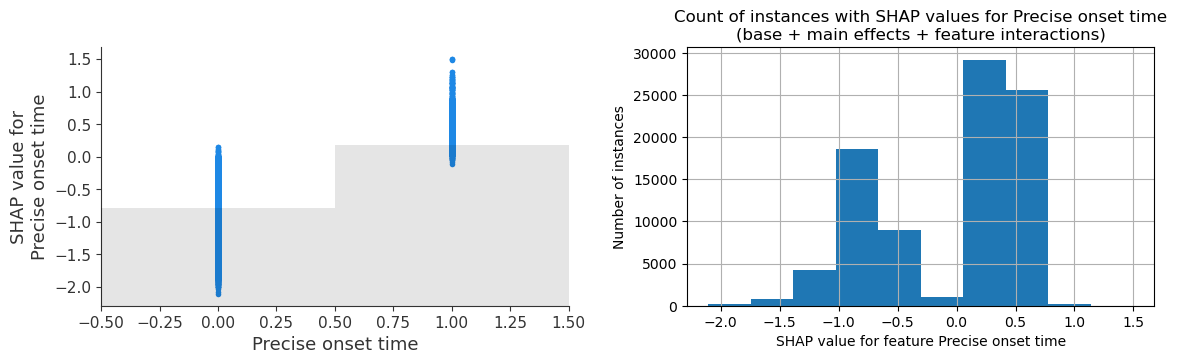

In [17]:
fig = plt.figure(figsize=(12,4))

# Subplot 1: shap scatter plot

ax1 = fig.add_subplot(1,2,1)

shap.plots.scatter(shap_values[:, chosen_feature], x_jitter=0, ax=ax1,
                   show=False)

# Subplot 2: histogram

ax2 = fig.add_subplot(1,2,2)

ax2 = plt.hist(shap_values[:, chosen_feature])
plt.xlabel(f"SHAP value for feature {chosen_feature}")
plt.ylabel("Number of instances")
plt.title(f"Count of instances with SHAP values for {chosen_feature}\n"
          f"(base + main effects + feature interactions)")
plt.grid()

# Format figure

plt.tight_layout(pad=2)

plt.savefig(f'./output/{notebook}_{model_text}_hist_and_scatter_'
            f'{chosen_feature}_shap.jpg', dpi=300, bbox_inches='tight', 
            pad_inches=0.2)

plt.show()

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP interaction values - a value for each pair-wise feature (the sum of which give the SHAP values for each feature).

In [18]:
%%time

filename = f'./output/03b_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    # Get SHAP interaction values
    shap_interaction = explainer.shap_interaction_values(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_interaction, filehandler)

CPU times: user 0 ns, sys: 2.76 s, total: 2.76 s
Wall time: 2.77 s


SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [19]:
shap_interaction.shape

(88792, 141, 141)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [20]:
shap_interaction[0]

array([[ 6.76276624e-01,  4.08733338e-02,  1.05852485e-02, ...,
         1.75262336e-04,  1.55542511e-05, -3.98763688e-04],
       [ 4.08733785e-02,  3.38386327e-01,  5.30318618e-02, ...,
         0.00000000e+00,  0.00000000e+00,  6.54254109e-07],
       [ 1.05856061e-02,  5.30319214e-02,  8.62581849e-01, ...,
         1.82669377e-04,  3.62747931e-04,  8.75864644e-05],
       ...,
       [ 1.75237656e-04,  0.00000000e+00,  1.82688236e-04, ...,
         3.14869266e-03,  0.00000000e+00,  3.90200876e-06],
       [ 1.55568123e-05,  0.00000000e+00,  3.62753868e-04, ...,
         0.00000000e+00, -1.80786219e-03,  0.00000000e+00],
       [-3.98725271e-04,  6.55651093e-07,  8.76188278e-05, ...,
         3.90200876e-06,  0.00000000e+00,  3.13467532e-03]], dtype=float32)

### SHAP interaction matrix: show mean absolute values
Show the absolute mean of the SHAP interaction values for all of the instances the feature *precise onset time*. The value in the column "Precise onset time" shows the main effect for the feature, and the other values show the SHAP interaction for pairs of features.

In [21]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction).mean(axis=(0)),
    index=X.columns, columns=X.columns)

print(mean_abs_interactions.loc[[chosen_feature]].round(2))

                    Arrival-to-scan time  Infarction  Stroke severity  \
Precise onset time                  0.03        0.07             0.06   

                    Precise onset time  Prior disability level  \
Precise onset time                0.58                    0.02   

                    Use of AF anticoagulants  Onset-to-arrival time  \
Precise onset time                      0.01                   0.01   

                    Onset during sleep   Age  team_AGNOF1041H  ...  \
Precise onset time                0.02  0.01              0.0  ...   

                    team_XKAWN3771U  team_XPABC1435F  team_XQAGA4299B  \
Precise onset time              0.0              0.0              0.0   

                    team_XWUBX0795L  team_YEXCH8391J  team_YPKYH1768F  \
Precise onset time              0.0              0.0              0.0   

                    team_YQMZV4284N  team_ZBVSO0975W  team_ZHCLE1578P  \
Precise onset time              0.0              0.0              0.0

### The proportion of SHAP that is from the interactions: calculated from the absolute mean
Looking at all of the instances together, what proportion of the SHAP value comes from the SHAP interations and what from the main effect (for the feature "Precise onset time")

In [22]:
total_shap = mean_abs_interactions.loc[[chosen_feature]].sum().sum()

main_shap = (
    mean_abs_interactions[chosen_feature].loc[[chosen_feature]].values[0])

interaction_shap = total_shap - main_shap

print(f'For feature {chosen_feature}, the proportion of the SHAP values coming '
      f'from the interactions are: {interaction_shap/total_shap:0.3f}')
print(f'For feature {chosen_feature}, the proportion of the SHAP values coming '
      f'from the main effects are: {main_shap/total_shap:0.3f}')

For feature Precise onset time, the proportion of the SHAP values coming from the interactions are: 0.371
For feature Precise onset time, the proportion of the SHAP values coming from the main effects are: 0.629


## Show main effect for chosen feature
Need to always consult the main effect when interpreting the SHAP interactions

# KP NEED TO CORRECT CODE SO IT SHOWS JUST INTEGER XTICKS (LIKE IN THE SUBPLOTS BELOW)
# Add more jitter the fewer categories the feature has
n_categories = X[chosen_feature].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

# Set up the matrix of subplots
fig, ax = plt.subplots(111)

shap.dependence_plot((chosen_feature, chosen_feature), shap_interaction, X, 
                      display_features=X, x_jitter=x_jitter, show=False, ax=ax)

# If a binary category then only show the integer values on x axis
if n_categories == 2:
    ax.locator_params(axis="x", integer=True, tight=True)

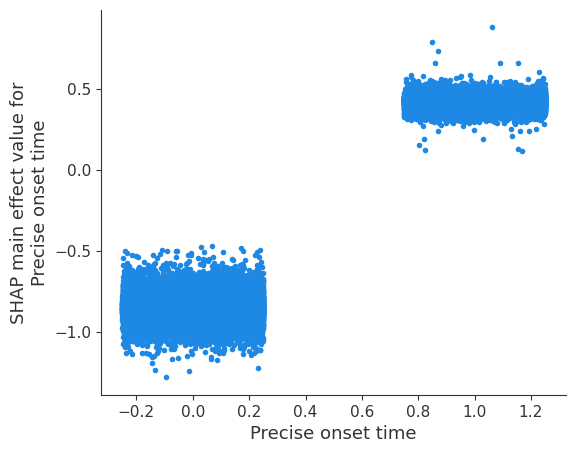

In [23]:
# Add more jitter the fewer categories the feature has
n_categories = X[chosen_feature].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

shap.dependence_plot((chosen_feature, chosen_feature), shap_interaction, X, 
                      display_features=X, x_jitter=x_jitter, show=False)

## SHAP dependence plots for the chosen feature

We will now show all of the SHAP interaction values between the chosen feature and all of the one-hot encoded hospital features.

Show just the row for Precise Onset Known vs the 132 hosptials (display them as a grid of subplots, but this is not a matrix, there is no logic to their position in the grid apart from the order in which they appear in the dataset).

How to interpret these plots: We are interested in where the red dots are (attending this hospital). We can ignore the blue dots for now.

Remember from notebook 12a that we need to consider the *precise onset time* main effect in combination with these interaction relationships. So refer to dependency plot of the main effect above. If have a best guess then contribute -0.5 to -1.5, if precise onset time then contribute ~ 0.5.

If the red dots are negative for column 0 (best guess) and positive for column 1 (precise) then the interaction between *precise onset time* and this hospital is that having a precise onset time contributes further to a more likely thrombolysis decision, and best estimate contributes further to a less likely thrombolysis decision. (This is what we would expect).

If the red dots are positive for column 0 (best guess) and negative for column 1 (precise) then the interaction between *precise onset time* and this hospital is undoing some of the main effect (the degree of which depends on the range of the values).

If red dots are neutral for both column 0 (best guess) and column 1 (precise) then there is no interaction between *precise onset time* and this hospital - this hospital agrees with what in captured already in the main effect.

Resources used to make the grid of dependence plots: https://stackoverflow.com/questions/58510005/python-shap-package-how-to-plot-a-grid-of-dependence-plots \
(for future reference, but not yet used here: https://gist.github.com/eddjberry/3c1818a780d3cb17390744d6e215ba4d)

### Find common ymin and ymax so each subplot on same scale

In [24]:
chosen_feature_index = X.columns.to_list().index(chosen_feature)
hospital_names_ohe = X_hosp.columns
hosp_start_index = X.columns.to_list().index(hospital_names_ohe[0])
ylim_min1 = shap_interaction[:,chosen_feature_index, hosp_start_index:].min().min()
ylim_min2 = shap_interaction[:, hosp_start_index:,chosen_feature_index].min().min()
ylim_min = min(ylim_min1, ylim_min2)

ylim_max1 = shap_interaction[:,chosen_feature_index, hosp_start_index:].max().max()
ylim_max2 = shap_interaction[:, hosp_start_index:,chosen_feature_index].max().max()
ylim_max = min(ylim_max1, ylim_max2)

print(f"{ylim_min}, {ylim_max}")

-1.0136072635650635, 0.9460151791572571


In [25]:
hosp_index = X.columns.to_list().index("team_TPXYE0168D")
shap_interaction[:,chosen_feature_index, hosp_index:].max()

0.9460152

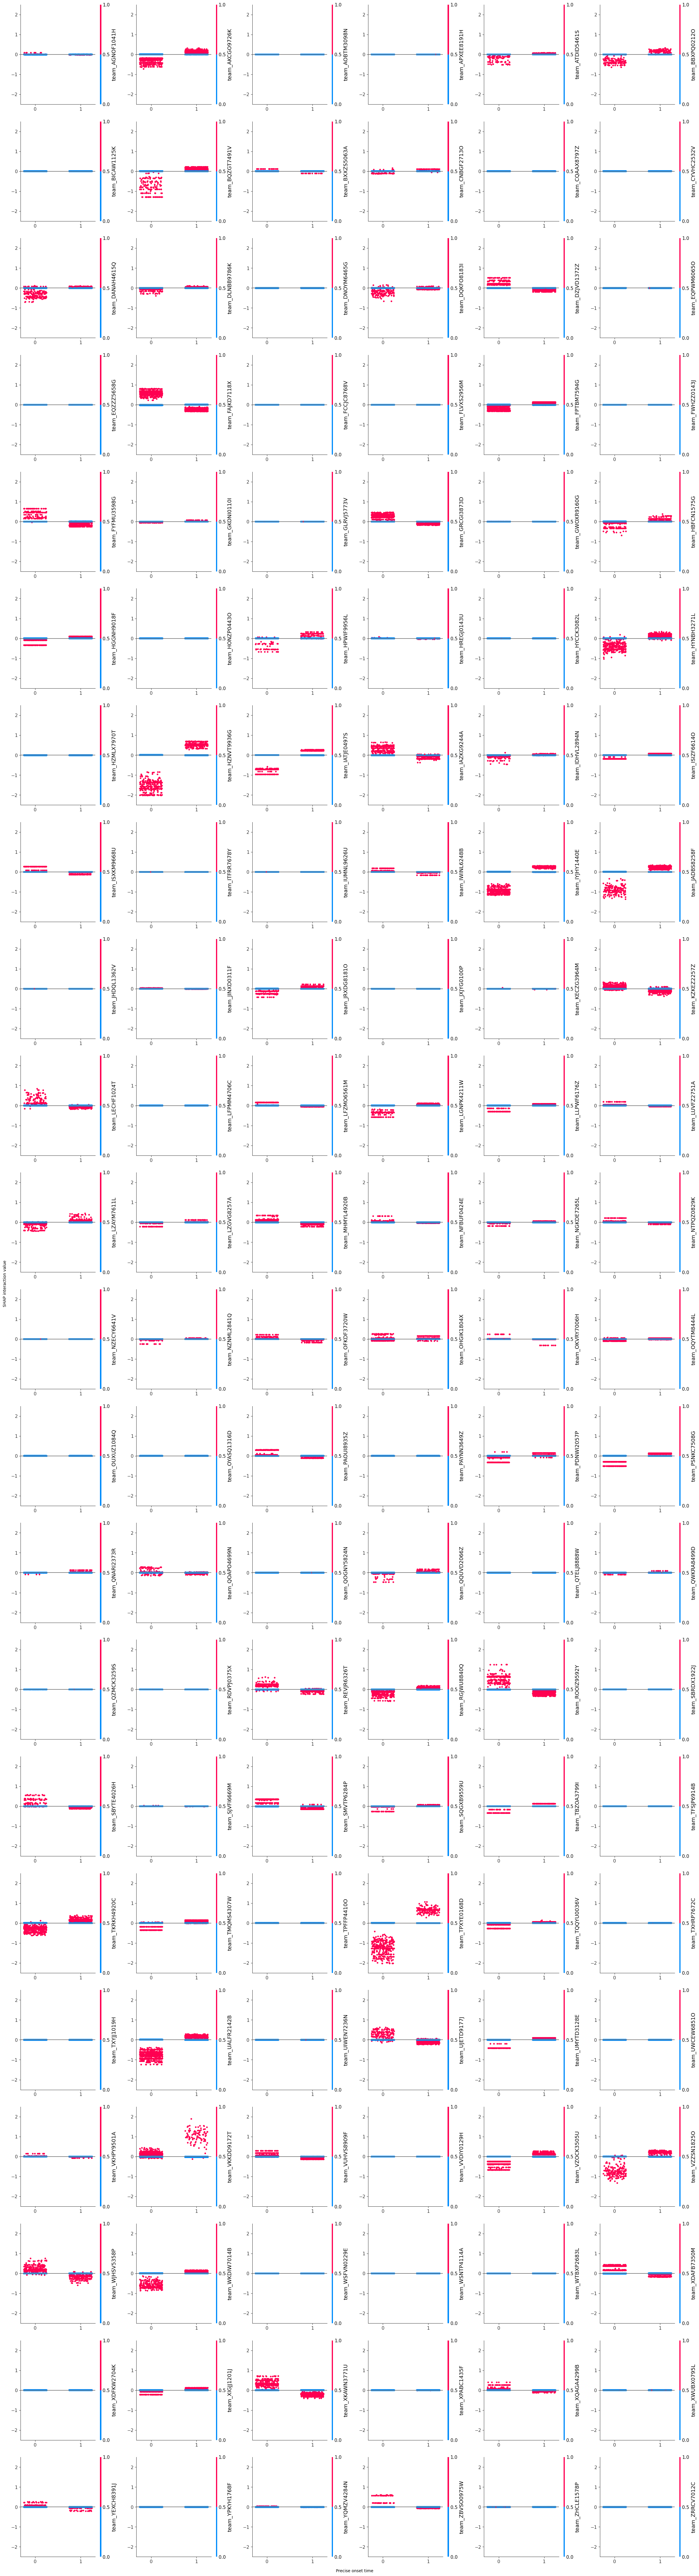

In [26]:
import matplotlib.ticker as ticker

# Get list of hospital one hot encoded column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Number of subplots per row (the number of columns)
ncols = 6
if (n_hospitals/ncols).is_integer():
    nrows = int(n_hospitals/ncols)
else:
    nrows = int((n_hospitals/ncols)+1)

# Show dependency plots from the row

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows = nrows, 
    ncols = ncols)
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f2 in hospital_names_ohe:

    # Add more jitter the fewer categories the feature has
    n_categories = X[chosen_feature].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (chosen_feature, f2), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[chosen_feature].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5') 
    
    # If a binary category then only show the integer values on x axis
    if n_categories == 2:
        axes[count].locator_params(axis="x", integer=True, tight=True)
#        axes[count].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    # Tailor which plots get which information
    #   First column gets y label
#    if (count/ncols).is_integer():
#        axes[count].set_ylabel("SHAP interaction value")
#    else:
    axes[count].set_ylabel("")
    axes[count].set_xlabel("")

#    axes[count].set_ylim((ylim_min, ylim_max))
    axes[count].set_ylim((-2.5, 2.5))

    count += 1

fig.text(0.5, 0, 'Precise onset time', ha='center')
fig.text(0, 0.5, 'SHAP interaction value' , va='center', rotation='vertical')
   
# Visual properties of figure
dimension = 4 * ncols
fig.set_figheight(dimension * (nrows/ncols))
fig.set_figwidth(dimension)
plt.tight_layout(pad=2)
#fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

All the information is in the red data points - those instances attending that hosptial. Show just the data of the instances that attend the hostpials. These are displayed as a grid of subplots, in hospital alphabetical order.

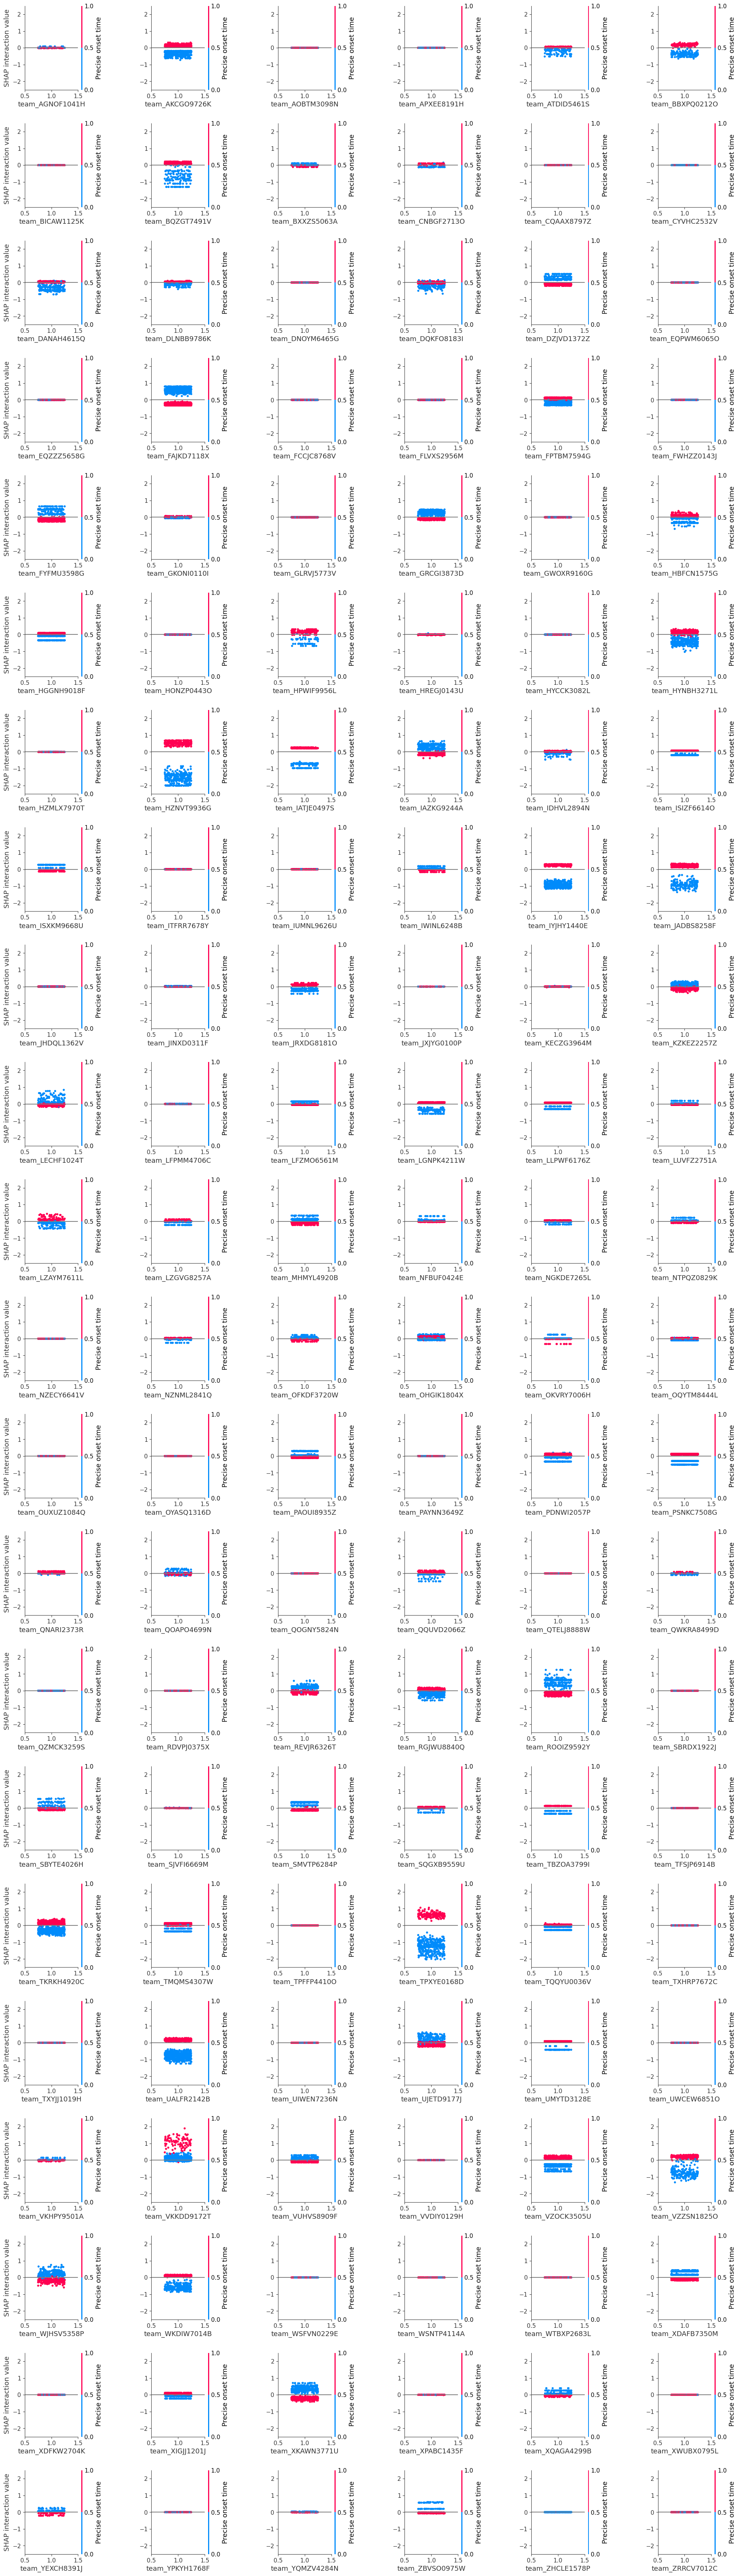

In [27]:
# Show dependency plots from the column

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows = nrows, 
    ncols = ncols)
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f1 in hospital_names_ohe:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (f1, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
    
    # Remove 0 column (all the information is in the "1" attended hospital column)
    axes[count].set_xlim((0.5,1.5))
    
    # If a binary category then only show the integer values on x axis
    if n_categories == 2:
        axes[count].locator_params(axis="x", integer=True, tight=True)
#        axes[count].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Tailor which plots get which information
    #   First column gets y label
    if (count/ncols).is_integer():
        axes[count].set_ylabel("SHAP interaction value")
    else:
        axes[count].set_ylabel("")

#    axes[count].set_ylim((ylim_min, ylim_max))
    axes[count].set_ylim((-2.5, 2.5))
#    #   Last column legend
#    if not ((count+1)/ncols).is_integer():
#        axes[count].legend().set_visible(False)
    count += 1

# Visual properties of figure
dimension = 4 * ncols
fig.set_figheight(dimension * (nrows/ncols))
fig.set_figwidth(dimension)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

Column for "0" team is representing if don't attend that hospital. That's not a useful thing to look at, so olny show column "1".

The "1" column shows data for the patients that attended that hospital. Red represents those patients with a precise known onset time, blue represents patients with a best estimate onset time. Where the red and blue exist in relation to the sign of the SHAP (negative or positive) shows how this hospital uses this information - in addition to the main effect (that being best estimate between, and precise known between ).

Can group hospitals into 3 categories.
1) Precise contributes to more likely thrombolysis, best estimate contributes to less likely thrombolysis
2) Precise contributes to less likely thrombolysis, best estimate contributes to more likely thrombolysis
3) Status of onset has no impact

An example of (1) is the last hosptial (ZRRCV) has red (precise) in the positive SHAP. Blue (estimate) in negative SHAP. So the interaction between precise onset time and this hospital is that having a precise onset time contributes to a more likely thrombolysis decision, and best estimate contributes to a less likely thrombolysis decision. (This is what we would expect).

An example of (2) is the first hosptial (AGNOF) has red (precise) in the negative SHAP. Blue (estimate) in positive SHAP. So the interaction between precise onset time and this hospital is that having a precise onset time contributes to a less likely thrombolysis decision, and best estimate contributes to a more likely thrombolysis decision. (This is the opposite to what we would expect).

An example of (3) is hosptial YPKYH which has red (precise) and blue (estimate) all on zero SHAP. So there is no interaction between precise onset time and this hospital - this hospital does not appear to use this information for it's thrombolysis decision making.

## Show a comparison of teams with different interaction direction

team_HZNVT9936G has a greater aversion to giving thrombolysis than the main effect of stroke onste time type.

team_FAJKD7118X has a reduced aversion to giving thrombolysis than the main effect of stroke onste time type.

Examining the precise onset time main effects:

In [28]:
feature  = "Precise onset time"
feature_loc = (list(X.columns)).index(feature)
feature_main_effect = shap_interaction[:,feature_loc, feature_loc]

df = pd.DataFrame(X[feature].copy(deep=True))
df.rename(columns={"Precise onset time":"values"}, inplace=True)
df["main effect"] = feature_main_effect

df.groupby(["values"]).mean()

,main effect
values,
0,-0.848683
1,0.423840


Examining the *team* main effects:

In [29]:
for f1 in ['team_HZNVT9936G','team_FAJKD7118X']:
    feature_loc = (list(X.columns)).index(f1)
    feature_main_effect = shap_interaction[:,feature_loc, feature_loc]
    feature_shap_value = shap_interaction[:,feature_loc, :].sum(axis=1)

    df = pd.DataFrame(X[f1].copy(deep=True))
    df.rename(columns={f1:"data value"}, inplace=True)
    df["main effect"] = feature_main_effect
    df["shap value"] = feature_shap_value
    print(f"Hosptial {f1} SHAP (main effect & values) for patients attending (1) and not (0)")
    print(df.groupby(["data value"]).mean())
    print ()

Hosptial team_HZNVT9936G SHAP (main effect & values) for patients attending (1) and not (0)
            main effect  shap value
data value                         
0             -0.001734   -0.001082
1              0.262858    0.037823

Hosptial team_FAJKD7118X SHAP (main effect & values) for patients attending (1) and not (0)
            main effect  shap value
data value                         
0              0.008062    0.006787
1             -0.265043   -0.259819



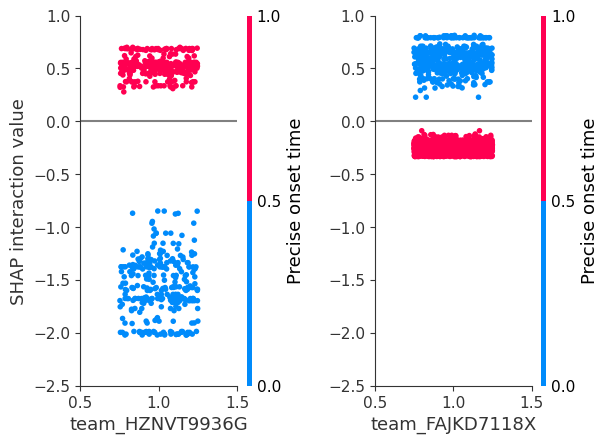

In [30]:
# Show dependency plots from the column

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows = 1, 
    ncols = 2)
axes = axes.ravel()

count = 0
for f1 in ['team_HZNVT9936G','team_FAJKD7118X']:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (f1, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
    
    # Remove 0 column (all information is in "1" for attended hospital column)
    axes[count].set_xlim((0.5,1.5))
    
    # Tailor which plots get which information
    #   First column gets y label
    if (count/ncols).is_integer():
        axes[count].set_ylabel("SHAP interaction value")
    else:
        axes[count].set_ylabel("")

    axes[count].set_ylim((-2.5, 1.0))
    count += 1

plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_{chosen_feature}_interaction_'
            f'example.jpg', dpi=300)
plt.show()

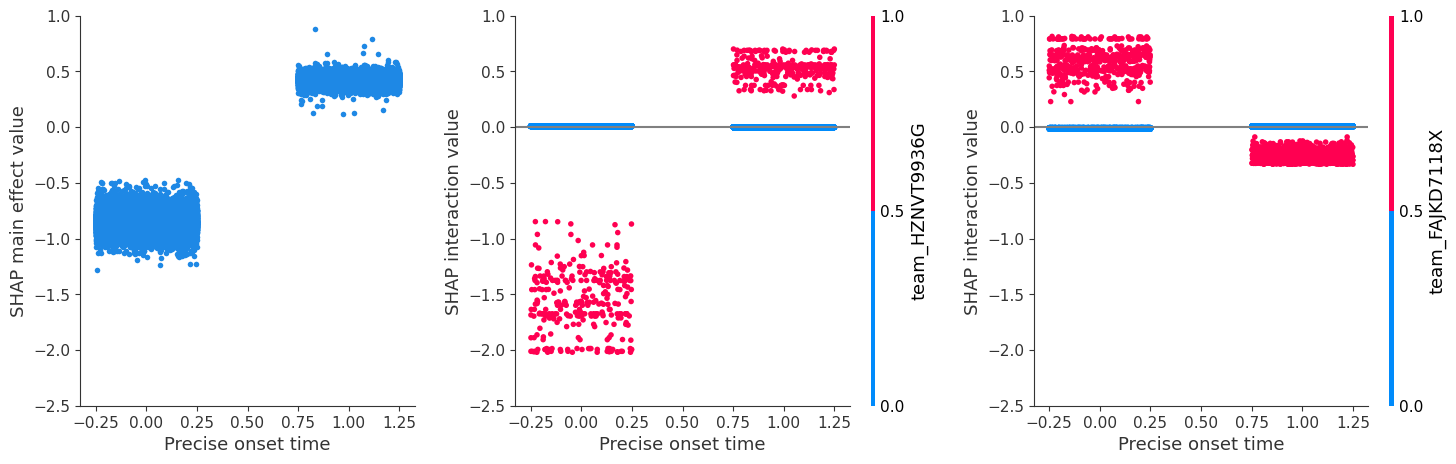

In [31]:
# Show dependency plots from the column
chosen_feature = 'Precise onset time'

# Set up the matrix of subplots
#   Using gridspec_kw to give the visual appearance of all plots having same
#   width, otherwise main effect plot looked wider (maybe due to no legend?)
fig, axes = plt.subplots(nrows=1, ncols=3, 
                         gridspec_kw={'width_ratios': [0.8,1,1]})
axes = axes.ravel()

# Plot main effect
shap.dependence_plot(
    (chosen_feature, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
    display_features=X, show=False, ax=axes[0])
axes[0].set_ylabel("SHAP main effect value")
axes[0].set_ylim((-2.5, 1.0))

# Plot interactions
count = 1
for f1 in ['team_HZNVT9936G','team_FAJKD7118X']:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (chosen_feature, f1), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
    
    # Remove 0 column (all information is in "1" for attended hospital column)
#    axes[count].set_xlim((0.5,1.5))
    
    # Tailor which plots get which information
    #   First column gets y label
    #if (count/ncols).is_integer():
#        axes[count].set_ylabel("SHAP interaction value")
#    else:
#        axes[count].set_ylabel("")

    axes[count].set_ylabel("SHAP interaction value")

    axes[count].set_ylim((-2.5, 1.0))
    count += 1

fig.set_figheight(5)
fig.set_figwidth(15)
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_{chosen_feature}_interaction_'
            f'example_with_main_effect.jpg', dpi=300)
plt.show()

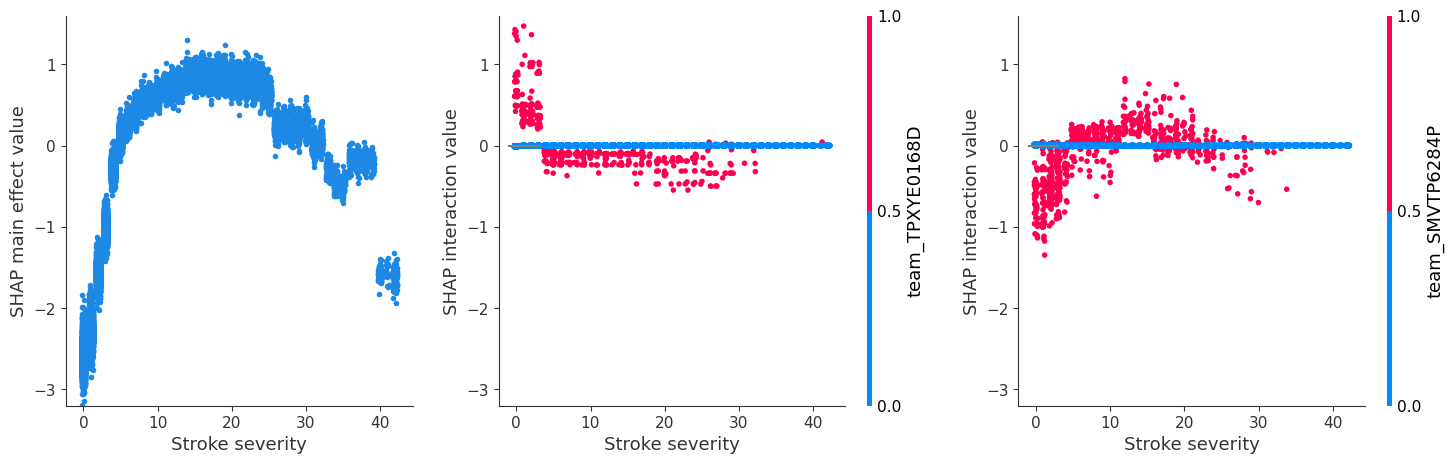

In [32]:
# Show dependency plots from the column
chosen_feature = 'Stroke severity'

# Set up the matrix of subplots
#   Using gridspec_kw to give the visual appearance of all plots having same
#   width, otherwise main effect plot looked wider (maybe due to no legend?)
fig, axes = plt.subplots(nrows=1, ncols=3, 
                         gridspec_kw={'width_ratios': [0.8,1,1]})
axes = axes.ravel()

# Plot main effect
shap.dependence_plot(
    (chosen_feature, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
    display_features=X, show=False, ax=axes[0])
axes[0].set_ylabel("SHAP main effect value")
axes[0].set_ylim((-3.2, 1.6))


# Plot interactions
count = 1
for f1 in ['team_TPXYE0168D','team_SMVTP6284P']:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (chosen_feature, f1), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
    
    # Remove 0 column (all information is in "1" for attended hospital column)
#    axes[count].set_xlim((0.5,1.5))
    
    # Tailor which plots get which information
    #   First column gets y label
    #if (count/ncols).is_integer():
#        axes[count].set_ylabel("SHAP interaction value")
#    else:
#        axes[count].set_ylabel("")

    axes[count].set_ylabel("SHAP interaction value")

    axes[count].set_ylim((-3.2, 1.6))
    count += 1

fig.set_figheight(5)
fig.set_figwidth(15)
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_{chosen_feature}_interaction_'
            f'example_with_main_effect.jpg', dpi=300)
plt.show()

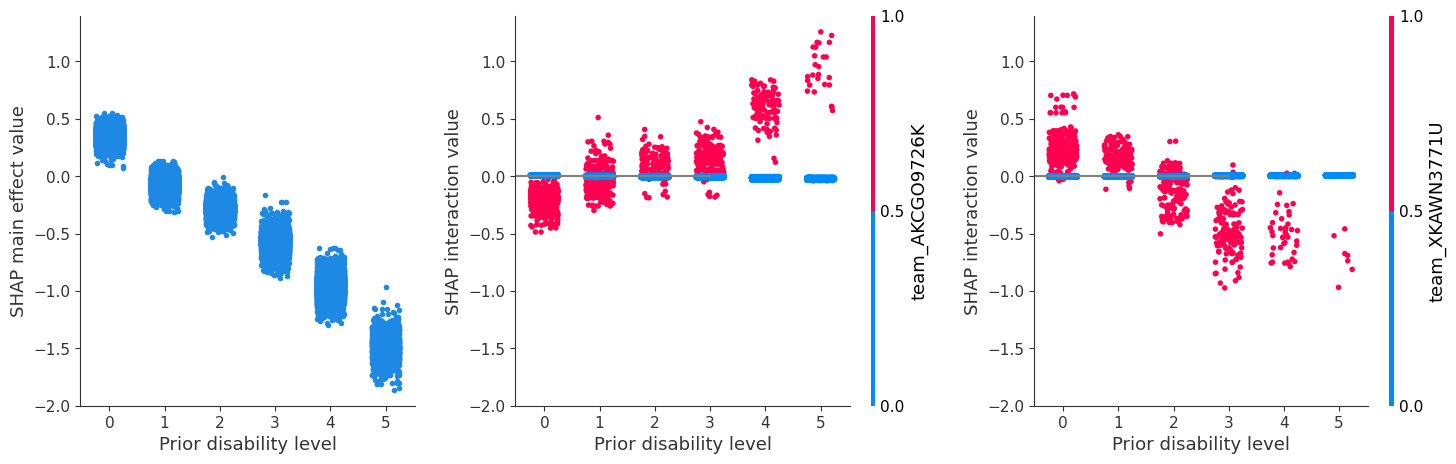

In [33]:
# Show dependency plots from the column
chosen_feature = 'Prior disability level'
# Set up the matrix of subplots
#   Using gridspec_kw to give the visual appearance of all plots having same
#   width, otherwise main effect plot looked wider (maybe due to no legend?)
fig, axes = plt.subplots(nrows=1, ncols=3, 
                         gridspec_kw={'width_ratios': [0.8,1,1]})
axes = axes.ravel()

# Plot main effect
shap.dependence_plot(
    (chosen_feature, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
    display_features=X, show=False, ax=axes[0])
axes[0].set_ylabel("SHAP main effect value")
axes[0].set_ylim((-2, 1.4))

# Plot interactions
count = 1
for f1 in ['team_AKCGO9726K','team_XKAWN3771U']:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (chosen_feature, f1), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
    
    # Remove 0 column (all information is in "1" for attended hospital column)
#    axes[count].set_xlim((0.5,1.5))
    
    # Tailor which plots get which information
    #   First column gets y label
    #if (count/ncols).is_integer():
#        axes[count].set_ylabel("SHAP interaction value")
#    else:
#        axes[count].set_ylabel("")

    axes[count].set_ylabel("SHAP interaction value")

    axes[count].set_ylim((-2, 1.4))
    count += 1

fig.set_figheight(5)
fig.set_figwidth(15)
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_{chosen_feature}_interaction_'
            f'example_with_main_effect.jpg', dpi=300)
plt.show()

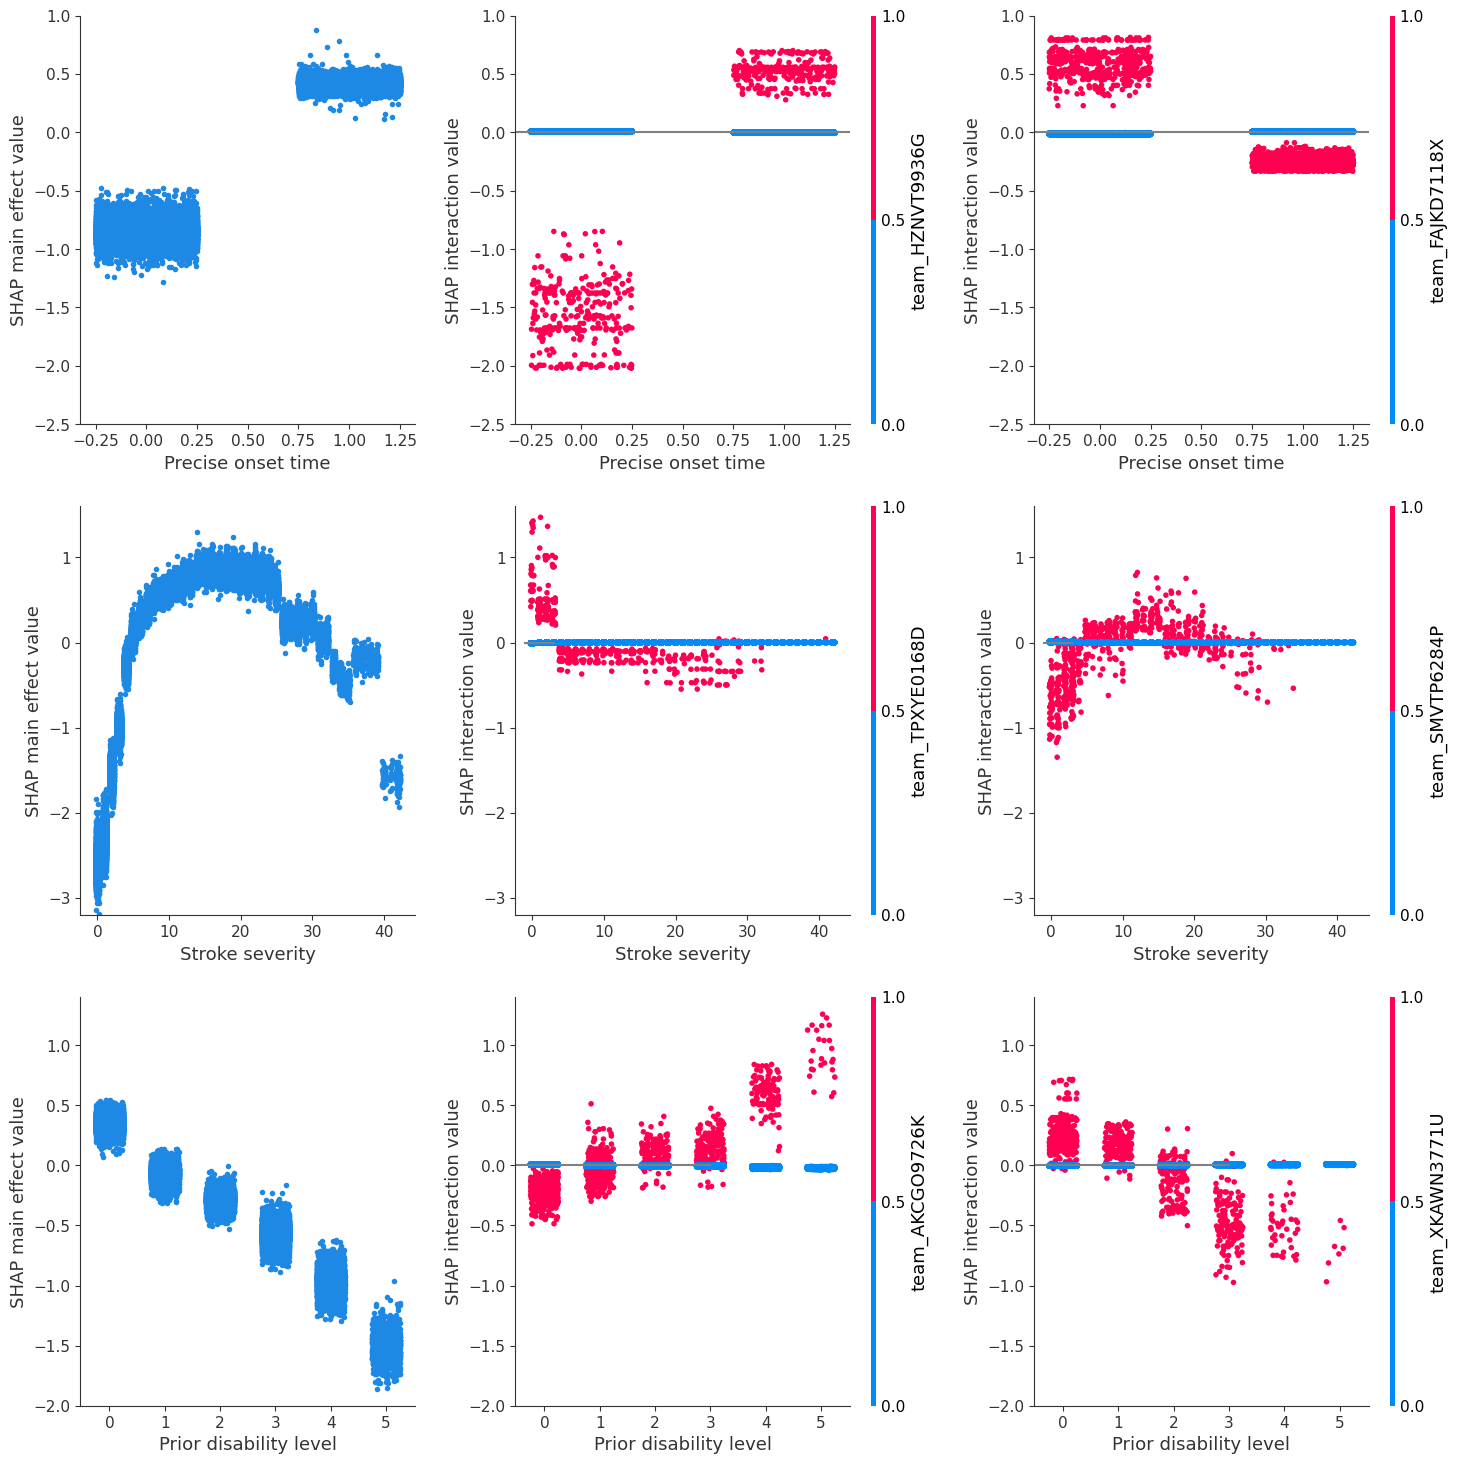

In [34]:
# Set up the matrix of subplots
#   Using gridspec_kw to give the visual appearance of all plots having same
#   width, otherwise main effect plot looked wider (maybe due to no legend?)
fig, axes = plt.subplots(nrows=3, ncols=3, 
                         gridspec_kw={'width_ratios': [0.8,1,1]})
axes = axes.ravel()
count = 0

# Show dependency plots from the column
chosen_feature = 'Precise onset time'

# Plot main effect
shap.dependence_plot(
    (chosen_feature, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
    display_features=X, show=False, ax=axes[count])
axes[count].set_ylabel("SHAP main effect value")
axes[count].set_ylim((-2.5, 1.0))

# Plot interactions
count += 1
for f1 in ['team_HZNVT9936G','team_FAJKD7118X']:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (chosen_feature, f1), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   

    axes[count].set_ylabel("SHAP interaction value")

    axes[count].set_ylim((-2.5, 1.0))
    count += 1

# Show dependency plots from the column
chosen_feature = 'Stroke severity'

# Plot main effect
shap.dependence_plot(
    (chosen_feature, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
    display_features=X, show=False, ax=axes[count])
axes[count].set_ylabel("SHAP main effect value")
axes[count].set_ylim((-3.2, 1.6))

count += 1

# Plot interactions
for f1 in ['team_TPXYE0168D','team_SMVTP6284P']:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (chosen_feature, f1), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5') 

    axes[count].set_ylabel("SHAP interaction value")

    axes[count].set_ylim((-3.2, 1.6))
    count += 1

# Show dependency plots from the column
chosen_feature = 'Prior disability level'

# Plot main effect
shap.dependence_plot(
    (chosen_feature, chosen_feature), shap_interaction, X, x_jitter=x_jitter, 
    display_features=X, show=False, ax=axes[count])
axes[count].set_ylabel("SHAP main effect value")
axes[count].set_ylim((-2, 1.4))

# Plot interactions
count += 1
for f1 in ['team_AKCGO9726K','team_XKAWN3771U']:

    # Add more jitter the fewer categories the feature has
    n_categories = X[f1].nunique()
    x_jitter = max(0, 0.7 - (n_categories * 0.1))

    # Plot data
    shap.dependence_plot(
        (chosen_feature, f1), shap_interaction, X, x_jitter=x_jitter, 
        display_features=X, show=False, ax=axes[count])

    # Add line at Shap = 0
    n_classes = X[f1].nunique()
    axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   

    axes[count].set_ylabel("SHAP interaction value")

    axes[count].set_ylim((-2, 1.4))
    count += 1

fig.set_figheight(15)
fig.set_figwidth(15)
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_3_features_interaction_'
            f'example_with_main_effect.jpg', dpi=300)
plt.show()

In [35]:
def get_hospital_feature_interaction(team, feature):
    # Get feature names 
    cols = list(X)

    # Restrict SHAP interactions to hopsital
    mask = X[team] == 1
    hospital_interactions = shap_interaction[mask]

    # Get hospital and feature index
    hospital_index = cols.index(team)
    feature_index = cols.index(feature)

    # Put results in dataframe
    df = pd.DataFrame()

    # Get feature values for team
    df['feature values'] = X[mask][feature]

    # Get hopsital main effect
    df['hospital main effect'] = hospital_interactions[:, hospital_index, hospital_index]

    # Get feature main effect
    df['feature main effect'] = hospital_interactions[:, feature_index, feature_index]

    # Get interactions
    df['interaction'] = hospital_interactions[:, hospital_index, feature_index] * 2

    # Sum main effect and interaction
    df['feature main + interaction'] = df['feature main effect'] + df['interaction']

    # Get average effects
    grouped = df.groupby('feature values').mean().round(3)

    return df, grouped


In [36]:
team = 'team_AKCGO9726K'
feature = 'Prior disability level'

results, grouped = get_hospital_feature_interaction(team, feature)
grouped

,hospital main effect,feature main effect,interaction,feature main + interaction
feature values,,,,
0,0.460,0.346,-0.191,0.155
1,0.450,-0.078,-0.035,-0.114
2,0.458,-0.299,0.103,-0.196
3,0.450,-0.579,0.143,-0.436
4,0.423,-0.986,0.596,-0.390
5,0.469,-1.484,0.927,-0.556


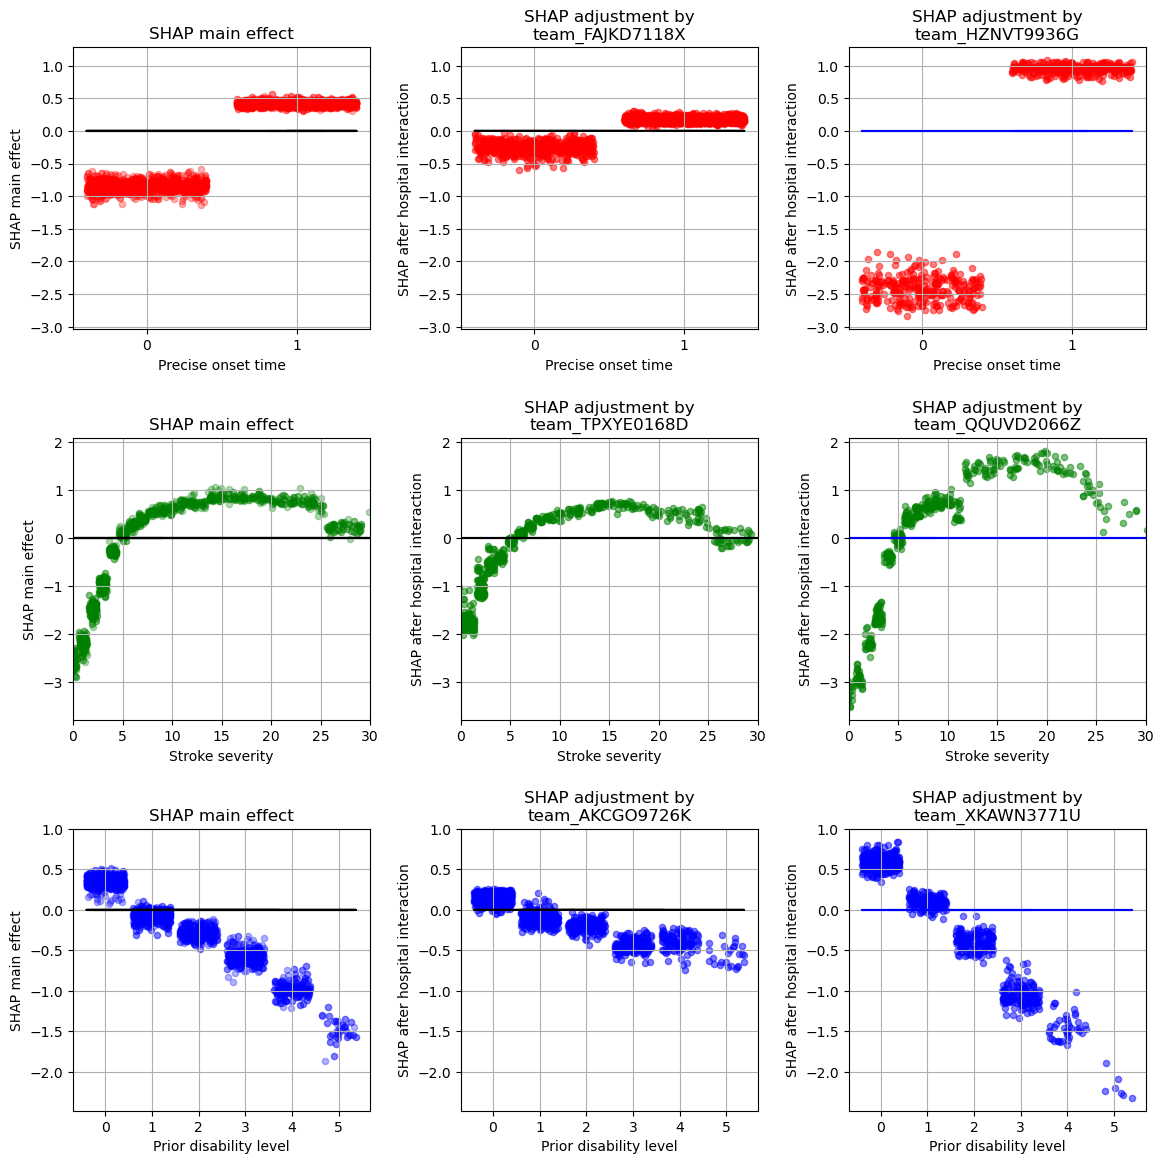

In [37]:
import matplotlib.ticker as ticker

feature = 'Prior disability level'

fig = plt.figure(figsize=(12,12))

####################################################################

ax1 = fig.add_subplot(331)

feature = 'Precise onset time'

team = 'team_FAJKD7118X'
results, grouped = get_hospital_feature_interaction(team, feature)


x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main effect']
ax1.scatter(x, y, s=20, alpha=0.5, c ='r')
ax1.set_ylabel('SHAP main effect')
ax1.set_title('SHAP main effect')
ax1.grid()
ax1.set_xlabel(f'{feature}')
ax1.plot(x, np.repeat(0, len(x)), color='k')

loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)

ax2 = fig.add_subplot(332, sharex=ax1, sharey=ax1)
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main + interaction']
ax2.scatter(x, y, s=20, alpha=0.5,c ='r')
ax2.set_ylabel('SHAP after hospital interaction')
ax2.set_title(f'SHAP adjustment by\n{team}')
ax2.grid()
ax2.set_xlabel(f'{feature}')
ax2.plot(x, np.repeat(0, len(x)), color='k')
ax2.xaxis.set_major_locator(loc)


team = 'team_HZNVT9936G'
results, grouped = get_hospital_feature_interaction(team, feature)

# Add main effect to plot 1
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main effect']
ax1.scatter(x, y, s=20, alpha=0.3, c ='r')
ax1.set_ylabel('SHAP main effect')
ax1.set_title('SHAP main effect')
ax1.set_xlabel(f'{feature}')
ax1.plot(x, np.repeat(0, len(x)), color='k')

ax3 = fig.add_subplot(333, sharex=ax1, sharey=ax1)
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main + interaction']
ax3.scatter(x, y, s=20, alpha=0.5,c ='r')
ax3.set_ylabel('SHAP after hospital interaction')
ax3.set_title(f'SHAP adjustment by\n{team}')
ax3.grid()
ax3.set_xlabel(f'{feature}')
ax3.plot(x, np.repeat(0, len(x)), color='b')
ax3.xaxis.set_major_locator(loc)

####################################################################

ax1 = fig.add_subplot(334)

feature = 'Stroke severity'

team = 'team_TPXYE0168D'
results, grouped = get_hospital_feature_interaction(team, feature)


x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main effect']
ax1.scatter(x, y, s=20, alpha=0.5, c ='g')
ax1.set_ylabel('SHAP main effect')
ax1.set_title('SHAP main effect')
ax1.grid()
ax1.set_xlabel(f'{feature}')
ax1.set_xlim(0,30)
ax1.set_xticks(np.arange(0,31,5))
ax1.plot(x, np.repeat(0, len(x)), color='k')

#loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
#ax1.xaxis.set_major_locator(loc)

ax2 = fig.add_subplot(335, sharex=ax1, sharey=ax1)
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main + interaction']
ax2.scatter(x, y, s=20, alpha=0.5,c ='g')
ax2.set_ylabel('SHAP after hospital interaction')
ax2.set_title(f'SHAP adjustment by\n{team}')
ax2.grid()
ax2.set_xlabel(f'{feature}')
ax2.plot(x, np.repeat(0, len(x)), color='k')
#ax2.xaxis.set_major_locator(loc)


team = 'team_QQUVD2066Z' #'team_SMVTP6284P'
results, grouped = get_hospital_feature_interaction(team, feature)

# Add main effect to plot 1
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main effect']
ax1.scatter(x, y, s=20, alpha=0.3, c ='g')
ax1.set_ylabel('SHAP main effect')
ax1.set_title('SHAP main effect')
ax1.set_xlabel(f'{feature}')
ax1.plot(x, np.repeat(0, len(x)), color='k')

ax3 = fig.add_subplot(336, sharex=ax1, sharey=ax1)
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main + interaction']
ax3.scatter(x, y, s=20, alpha=0.5,c ='g')
ax3.set_ylabel('SHAP after hospital interaction')
ax3.set_title(f'SHAP adjustment by\n{team}')
ax3.grid()
ax3.set_xlabel(f'{feature}')
ax3.plot(x, np.repeat(0, len(x)), color='b')
#ax3.xaxis.set_major_locator(loc)

####################################################################

ax1 = fig.add_subplot(337)

feature = 'Prior disability level'

team = 'team_AKCGO9726K'
results, grouped = get_hospital_feature_interaction(team, feature)


x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main effect']
ax1.scatter(x, y, s=20, alpha=0.5, c ='b')
ax1.set_ylabel('SHAP main effect')
ax1.set_title('SHAP main effect')
ax1.grid()
ax1.set_xlabel(f'{feature}')
ax1.plot(x, np.repeat(0, len(x)), color='k')

loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)

ax2 = fig.add_subplot(338, sharex=ax1, sharey=ax1)
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main + interaction']
ax2.scatter(x, y, s=20, alpha=0.5,c ='b')
ax2.set_ylabel('SHAP after hospital interaction')
ax2.set_title(f'SHAP adjustment by\n{team}')
ax2.grid()
ax2.set_xlabel(f'{feature}')
ax2.plot(x, np.repeat(0, len(x)), color='k')
ax2.xaxis.set_major_locator(loc)


team = 'team_XKAWN3771U'
results, grouped = get_hospital_feature_interaction(team, feature)

# Add main effect to plot 1
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main effect']
ax1.scatter(x, y, s=20, alpha=0.3, c ='b')
ax1.set_ylabel('SHAP main effect')
ax1.set_title('SHAP main effect')
ax1.set_xlabel(f'{feature}')
ax1.plot(x, np.repeat(0, len(x)), color='k')

ax3 = fig.add_subplot(339, sharex=ax1, sharey=ax1)
x = results['feature values'].copy()
jitter = -0.4 + (np.random.random(len(x))*0.8)
x += jitter
y = results['feature main + interaction']
ax3.scatter(x, y, s=20, alpha=0.5,c ='b')
ax3.set_ylabel('SHAP after hospital interaction')
ax3.set_title(f'SHAP adjustment by\n{team}')
ax3.grid()
ax3.set_xlabel(f'{feature}')
ax3.plot(x, np.repeat(0, len(x)), color='b')
ax3.xaxis.set_major_locator(loc)


plt.tight_layout(pad=2)
plt.savefig('./output/12aa_three_way_shap_adjustment.jpg', dpi=300)
plt.show()

Notes:

* The main effect of the precise onset time is that if onset time is known precicely then SHAP (log odds) is increased by 0.42, otherwise it is reduced by 0.85.

* Team_HZNVT9936G has a slightly higher main effect for hopsital SHAP (0.26) than Team_FAJKD7118X -0.27). Team_HZNVT9936G also has interactions that strengthen the effect of precise onset time whereas Team_FAJKD7118X has interactions values that attenuate the main effect of precise onset time.

* This SHAP inetraction is also evidenced in looking at the predicted thrombolysis rate in subsets of the 10k cohort (see notebook 15 - thrombolysis rates in subgroups of the 10k cohort). Team_HZNVT9936G has a predicted thrombolysis use of 32% in all 10k patients, 100% of 'ideal thrombolysis candidates, and 0.5% in patients without precise stroke onset time. Team_FAJKD7118X has a predicted thrombolysis use of 24% in all 10k patients, 100% of 'ideal thrombolysis candidates, and 11% in patients without precise stroke onset time.

*Ideal thrombolysis candidate:

* Stroke severity NIHSS in range 10-25
* Arrival-to-scan time < 30 minutes
* Stroke type = infarction
* Precise onset time = True
* Prior diability level (mRS) = 0
* No use of AF anticoagulants
* Onset-to-arrival time < 90 minutes
* Age < 80 years
* Onset during sleep = False